# LSTM Stock Price Prediction Model

## Overview
This notebook implements a Long Short-Term Memory (LSTM) neural network for stock price prediction using **5 key features** that are easy to understand and explain to stakeholders.

## The 5 Key Features

Instead of using only the closing price, our model uses 5 intuitive features:

1. **Close Price** - The actual stock closing price (our main target)
   - What it means: The final price at market close each day
   - Why it matters: Historical prices show trends and patterns

2. **Volume** - Number of shares traded
   - What it means: How many shares were bought/sold that day
   - Why it matters: High volume indicates strong interest/conviction in price moves

3. **20-Day Moving Average (MA20)** - Average price over last 20 days
   - What it means: Smoothed trend line showing general direction
   - Why it matters: Helps identify if stock is trending up or down

4. **Volatility** - How much the price fluctuates
   - What it means: Standard deviation of daily returns over 20 days
   - Why it matters: High volatility = risky/unpredictable, Low volatility = stable

5. **RSI (Relative Strength Index)** - Momentum indicator (0-100)
   - What it means: Measures if stock is overbought (>70) or oversold (<30)
   - Why it matters: Helps predict potential reversals in price direction

## Model Architecture

**Simplified LSTM Design:**
- **2 LSTM Layers** with 64 hidden units each
- **Bidirectional processing** - looks at patterns from both past and future
- **Dropout (20%)** - prevents overfitting to training data
- **Output layer** - predicts next day's closing price

**How it works:**
1. Takes the last 60 days of these 5 features as input
2. LSTM layers learn patterns in the sequential data
3. Outputs a prediction for the next day's closing price

## Why These 5 Features?

- **Price (Close)**: The fundamental data - what we're predicting
- **Volume**: Confirms whether price moves are strong or weak
- **MA20**: Shows the overall trend without daily noise
- **Volatility**: Captures risk and uncertainty in the market
- **RSI**: Identifies potential turning points (reversals)

These 5 features together give the model information about:
- **Trend** (MA20)
- **Momentum** (RSI)
- **Risk** (Volatility)
- **Conviction** (Volume)
- **Price History** (Close)

## Usage
1. Select a stock ticker (default: 'A')
2. Run all cells in order
3. Model trains automatically and shows results
4. Review visualizations to understand predictions

## Important Notes
- **Educational purposes only** - Not financial advice
- **Past performance does not equal future results**
- Model shows what patterns exist in historical data
- Real markets affected by news, earnings, global events not captured here

## Key Parameters
- `n_past = 60`: Uses last 60 days to predict next day
- `hidden_size = 64`: LSTM memory capacity
- `num_layers = 2`: Two LSTM layers
- `dropout = 0.2`: 20% dropout for regularization
- `batch_size = 32`: Training batch size
- `num_epochs = 50`: Training iterations


In [54]:
# Step 0: Import Libraries

import os
import math
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
plt.style.use("seaborn-v0_8")


In [55]:
# enable GPU is running the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- CONFIG ----
DATA_ROOT = "../../data/archive"  
META_PATH = os.path.join(DATA_ROOT, "symbols_valid_meta.csv")

target_symbol = "A"          # <-- change to any valid symbol
n_past = 60                  # lookback window (days)
batch_size = 32

# LSTM hyperparameters
HIDDEN_SIZE = 128
NUM_LAYERS = 3
DROPOUT = 0.3
LR = 1e-4
NUM_EPOCHS = 80

# Walk-forward config (in years)
TRAIN_YEARS = 5
TEST_YEARS = 1


Using device: cpu


In [56]:
# Load symbol metadata
meta_df = pd.read_csv(META_PATH)

print("Meta columns:", meta_df.columns.tolist())
print("Number of symbols:", len(meta_df))

row = meta_df[meta_df["Symbol"] == target_symbol]
if row.empty:
    raise ValueError(f"Symbol {target_symbol} not found in metadata.")

is_etf = (row["ETF"].iloc[0] == "Y")
asset_type = "etfs" if is_etf else "stocks"

print(f"Selected symbol: {target_symbol} | ETF? {is_etf} | Folder: {asset_type}")


df = pd.read_csv(data_path)
print("\n")
print("Columns in CSV:", df.columns.tolist())
df.head()



Meta columns: ['Nasdaq Traded', 'Symbol', 'Security Name', 'Listing Exchange', 'Market Category', 'ETF', 'Round Lot Size', 'Test Issue', 'Financial Status', 'CQS Symbol', 'NASDAQ Symbol', 'NextShares']
Number of symbols: 8049
Selected symbol: A | ETF? False | Folder: stocks


Columns in CSV: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300.0
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100.0
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800.0
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600.0
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200.0


In [57]:
# Standardize Date column
if "Date" not in df.columns:
    if "date" in df.columns:
        df = df.rename(columns={"date": "Date"})
    else:
        raise KeyError("Could not find a 'Date' or 'date' column in the CSV.")

# Standardize Close
if "Close" not in df.columns:
    if "Adj Close" in df.columns:
        df = df.rename(columns={"Adj Close": "Close"})
    elif "close" in df.columns:
        df = df.rename(columns={"close": "Close"})
    else:
        raise KeyError("Could not find a 'Close', 'Adj Close', or 'close' column.")

# Volume column check
if "Volume" not in df.columns and "volume" in df.columns:
    df = df.rename(columns={"volume": "Volume"})

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print("Overall date range:", df["Date"].min().date(), "→", df["Date"].max().date())
df.head()


Overall date range: 1999-11-18 → 2025-12-01


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300.0
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100.0
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800.0
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600.0
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200.0


In [58]:
def add_technical_indicators(df_raw):
    """
    Assumes df_raw has at least: Date, Close, Volume.
    Adds:
      - log_return
      - log_volume
      - MA20
      - EMA12, EMA26
      - MACD, MACD_signal
      - Bollinger bands (Upper, Lower)
      - Volatility20 (std of log_return)
      - RSI(14)
    Returns a new DataFrame with these columns added.
    """
    df = df_raw.copy()

    # Handle missing close first (if any)
    df["Close"] = df["Close"].interpolate(method="linear", limit_direction="both")

    # Log return
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

    # Log volume (to compress scale)
    if "Volume" in df.columns:
        df["Volume_log"] = np.log1p(df["Volume"])
    else:
        df["Volume_log"] = 0.0  # fallback if no volume data

    # Moving averages
    df["MA20"] = df["Close"].rolling(window=20, min_periods=20).mean()

    # Exponential moving averages
    df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()

    # MACD and signal
    df["MACD"] = df["EMA12"] - df["EMA26"]
    df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # Bollinger Bands (20-day)
    rolling_std_20 = df["Close"].rolling(window=20, min_periods=20).std()
    df["BB_Mid"] = df["MA20"]
    df["BB_Upper"] = df["BB_Mid"] + 2 * rolling_std_20
    df["BB_Lower"] = df["BB_Mid"] - 2 * rolling_std_20

    # Volatility (20-day std of log returns)
    df["Volatility20"] = df["log_return"].rolling(window=20, min_periods=20).std()

    # RSI(14)
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    roll_up = gain.rolling(window=14, min_periods=14).mean()
    roll_down = loss.rolling(window=14, min_periods=14).mean()

    RS = roll_up / roll_down
    df["RSI"] = 100.0 - (100.0 / (1.0 + RS))

    # Drop initial rows with NaNs from indicators
    df = df.dropna().reset_index(drop=True)

    return df

feature_df = add_technical_indicators(df)
print("Feature columns:", feature_df.columns.tolist())
print("Date range after indicators:", feature_df["Date"].min().date(), "→", feature_df["Date"].max().date())
feature_df.head()


Feature columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log_return', 'Volume_log', 'MA20', 'EMA12', 'EMA26', 'MACD', 'MACD_signal', 'BB_Mid', 'BB_Upper', 'BB_Lower', 'Volatility20', 'RSI']
Date range after indicators: 1999-12-17 → 2025-12-01


,Date,Open,High,Low,Close,Adj Close,Volume,log_return,Volume_log,MA20,EMA12,EMA26,MACD,MACD_signal,BB_Mid,BB_Upper,BB_Lower,Volatility20,RSI
0,1999-12-17,33.172390,33.708870,32.501789,32.859444,28.260609,3708000.0,-0.028171,15.126003,31.209764,31.917851,31.582819,0.335032,0.192973,31.209764,34.216964,28.202563,0.050601,61.010841
1,1999-12-20,33.082977,33.574749,32.993561,33.530045,28.837358,1196800.0,0.020203,13.995163,31.442239,32.165881,31.727058,0.438823,0.242143,31.442239,34.409889,28.474589,0.046251,62.886609
2,1999-12-21,33.395924,33.395924,32.904148,33.351215,28.683558,2259400.0,-0.005348,14.630610,31.536123,32.348240,31.847366,0.500874,0.293889,31.536123,34.624298,28.447948,0.042443,60.424025
3,1999-12-22,33.351215,34.021816,33.127682,34.021816,29.260303,1905700.0,0.019908,14.460360,31.806599,32.605713,32.008436,0.597277,0.354567,31.806599,34.761229,28.851969,0.035694,59.856632
4,1999-12-23,33.977112,35.765381,33.932404,35.586552,30.606049,2159400.0,0.044966,14.585341,32.117310,33.064304,32.273482,0.790822,0.441818,32.117310,35.292816,28.941805,0.036418,63.636361


In [59]:
def generate_walkforward_splits(df, train_years=5, test_years=1):
    """
    Sliding-window walk-forward:
      Train: [train_start_year, ..., test_start_year-1]
      Test:  [test_start_year, ..., test_start_year+test_years-1]
    Returns a list of split dicts with date ranges.
    """
    years = df["Date"].dt.year
    min_year = years.min()
    max_year = years.max()

    splits = []

    # Test start year slides through the range
    for test_start_year in range(min_year + train_years, max_year - test_years + 1):
        train_start_year = test_start_year - train_years
        test_end_year = test_start_year + test_years - 1

        splits.append({
            "train_start": datetime(train_start_year, 1, 1),
            "train_end":   datetime(test_start_year - 1, 12, 31),
            "test_start":  datetime(test_start_year, 1, 1),
            "test_end":    datetime(test_end_year, 12, 31),
        })

    return splits

splits = generate_walkforward_splits(feature_df, train_years=TRAIN_YEARS, test_years=TEST_YEARS)
print(f"Generated {len(splits)} walk-forward folds.")
splits[:3]


Generated 21 walk-forward folds.


[{'train_start': datetime.datetime(1999, 1, 1, 0, 0),
  'train_end': datetime.datetime(2003, 12, 31, 0, 0),
  'test_start': datetime.datetime(2004, 1, 1, 0, 0),
  'test_end': datetime.datetime(2004, 12, 31, 0, 0)},
 {'train_start': datetime.datetime(2000, 1, 1, 0, 0),
  'train_end': datetime.datetime(2004, 12, 31, 0, 0),
  'test_start': datetime.datetime(2005, 1, 1, 0, 0),
  'test_end': datetime.datetime(2005, 12, 31, 0, 0)},
 {'train_start': datetime.datetime(2001, 1, 1, 0, 0),
  'train_end': datetime.datetime(2005, 12, 31, 0, 0),
  'test_start': datetime.datetime(2006, 1, 1, 0, 0),
  'test_end': datetime.datetime(2006, 12, 31, 0, 0)}]

In [60]:
def create_sequences_np(features, targets, n_past):
    """
    features: np.array of shape (T, num_features)
    targets: np.array of shape (T,)
    n_past: int (window size)

    Returns:
        X: (num_samples, n_past, num_features)
        y: (num_samples,)
    """
    X, y = [], []
    for i in range(n_past, len(features)):
        X.append(features[i - n_past:i, :])
        y.append(targets[i])
    return np.array(X), np.array(y)


In [61]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.3):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, 1)  # *2 for bidirectional

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))      # (batch, seq_len, hidden_size*2)
        last_hidden = out[:, -1, :]          # last timestep
        last_hidden = self.dropout(last_hidden)
        out = self.fc(last_hidden)           # (batch, 1)
        return out.squeeze(-1)               # (batch,)


In [62]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(dataloader.dataset)


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return running_loss / len(dataloader.dataset), all_targets, all_preds


def directional_accuracy(y_true, y_pred):
    """
    Directional accuracy: how often the sign of change is correct.
    """
    true_dir = np.sign(np.diff(y_true))
    pred_dir = np.sign(np.diff(y_pred))
    # Align lengths
    n = min(len(true_dir), len(pred_dir))
    if n == 0:
        return np.nan
    return (true_dir[:n] == pred_dir[:n]).mean() * 100.0


In [63]:
feature_cols = [
    "Close", "log_return", "Volume_log",
    "MA20", "EMA12", "EMA26",
    "MACD", "MACD_signal",
    "BB_Upper", "BB_Lower",
    "Volatility20", "RSI"
]
target_col = "Close"

fold_results = []
last_fold_plot_data = None  # to keep data for visualization later

for fold_idx, s in enumerate(splits, start=1):
    print(f"\n=== Fold {fold_idx}: "
          f"Train {s['train_start'].date()} → {s['train_end'].date()} | "
          f"Test {s['test_start'].date()} → {s['test_end'].date()} ===")

    # Subset by date
    train_mask = (feature_df["Date"] >= s["train_start"]) & (feature_df["Date"] <= s["train_end"])
    test_mask  = (feature_df["Date"] >= s["test_start"]) & (feature_df["Date"] <= s["test_end"])

    train_df = feature_df.loc[train_mask].copy()
    test_df  = feature_df.loc[test_mask].copy()

    if len(train_df) < n_past + 10 or len(test_df) < n_past + 10:
        print("  Skipping fold due to insufficient data.")
        continue

    # Extract raw features and target
    X_train_raw = train_df[feature_cols].values
    y_train_raw = train_df[target_col].values

    X_test_raw  = test_df[feature_cols].values
    y_test_raw  = test_df[target_col].values

    # Scale features and target using only training data
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_train_raw)
    X_train_scaled = feat_scaler.transform(X_train_raw)
    X_test_scaled  = feat_scaler.transform(X_test_raw)

    target_scaler = MinMaxScaler()
    target_scaler.fit(y_train_raw.reshape(-1, 1))
    y_train_scaled = target_scaler.transform(y_train_raw.reshape(-1, 1)).flatten()
    y_test_scaled  = target_scaler.transform(y_test_raw.reshape(-1, 1)).flatten()

    # Create sequences
    X_train_seq, y_train_seq = create_sequences_np(X_train_scaled, y_train_scaled, n_past)
    X_test_seq,  y_test_seq  = create_sequences_np(X_test_scaled,  y_test_scaled,  n_past)

    print("  X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
    print("  X_test_seq: ", X_test_seq.shape, "y_test_seq: ", y_test_seq.shape)

    # Build DataLoaders
    X_train_tensor = torch.from_numpy(X_train_seq).float()
    y_train_tensor = torch.from_numpy(y_train_seq).float()
    X_test_tensor  = torch.from_numpy(X_test_seq).float()
    y_test_tensor  = torch.from_numpy(y_test_seq).float()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)

    # Build a fresh model for this fold
    model = StockLSTM(
        input_size=len(feature_cols),
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )

    best_test_loss = float("inf")
    best_state_dict = None

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, _, _ = evaluate_model(model, test_loader, criterion, device)

        scheduler.step(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_state_dict = model.state_dict()

        if epoch == 1 or epoch % 10 == 0:
            print(f"  Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

    # Load best weights for this fold
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    # Final evaluation on this fold
    _, y_train_scaled_out, y_train_pred_scaled = evaluate_model(model, train_loader, criterion, device)
    _, y_test_scaled_out,  y_test_pred_scaled  = evaluate_model(model, test_loader,  criterion, device)

    # Inverse scale
    y_train_true = target_scaler.inverse_transform(y_train_scaled_out.reshape(-1, 1)).flatten()
    y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

    y_test_true = target_scaler.inverse_transform(y_test_scaled_out.reshape(-1, 1)).flatten()
    y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

    # Metrics on test set
    rmse = math.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae = mean_absolute_error(y_test_true, y_test_pred)
    mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100.0
    dacc = directional_accuracy(y_test_true, y_test_pred)

    print(f"  Fold {fold_idx} Test RMSE: {rmse:.4f}")
    print(f"  Fold {fold_idx} Test MAE : {mae:.4f}")
    print(f"  Fold {fold_idx} Test MAPE: {mape:.2f}%")
    print(f"  Fold {fold_idx} Directional Accuracy: {dacc:.2f}%")

    fold_results.append({
        "fold": fold_idx,
        "train_start": s["train_start"].date(),
        "train_end":   s["train_end"].date(),
        "test_start":  s["test_start"].date(),
        "test_end":    s["test_end"].date(),
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "dir_acc": dacc
    })

    # Save last fold data for plotting
    last_fold_plot_data = {
        "dates": test_df["Date"].values[n_past:],
        "actual": y_test_true,
        "pred": y_test_pred
    }

results_df = pd.DataFrame(fold_results)
results_df



=== Fold 1: Train 1999-01-01 → 2003-12-31 | Test 2004-01-01 → 2004-12-31 ===
  X_train_seq: (954, 60, 12) y_train_seq: (954,)
  X_test_seq:  (192, 60, 12) y_test_seq:  (192,)
  Epoch 001 | Train Loss: 0.021730 | Test Loss: 0.006863
  Epoch 010 | Train Loss: 0.001223 | Test Loss: 0.000185
  Epoch 020 | Train Loss: 0.000911 | Test Loss: 0.000178
  Epoch 030 | Train Loss: 0.000937 | Test Loss: 0.000248
  Epoch 040 | Train Loss: 0.000874 | Test Loss: 0.000223
  Epoch 050 | Train Loss: 0.000895 | Test Loss: 0.000236
  Epoch 060 | Train Loss: 0.000882 | Test Loss: 0.000229
  Epoch 070 | Train Loss: 0.000807 | Test Loss: 0.000229
  Epoch 080 | Train Loss: 0.000878 | Test Loss: 0.000229
  Fold 1 Test RMSE: 1.6040
  Fold 1 Test MAE : 1.2910
  Fold 1 Test MAPE: 7.25%
  Fold 1 Directional Accuracy: 50.79%

=== Fold 2: Train 2000-01-01 → 2004-12-31 | Test 2005-01-01 → 2005-12-31 ===
  X_train_seq: (1196, 60, 12) y_train_seq: (1196,)
  X_test_seq:  (192, 60, 12) y_test_seq:  (192,)
  Epoch 001 | T

,fold,train_start,train_end,test_start,test_end,rmse,mae,mape,dir_acc
0,1,1999-01-01,2003-12-31,2004-01-01,2004-12-31,1.604028,1.290997,7.245824,50.785340
1,2,2000-01-01,2004-12-31,2005-01-01,2005-12-31,1.248242,1.064610,5.455250,56.020942
2,3,2001-01-01,2005-12-31,2006-01-01,2006-12-31,0.700031,0.547033,2.255855,48.947368
3,4,2002-01-01,2006-12-31,2007-01-01,2007-12-31,0.598417,0.456664,1.739622,47.894737
4,5,2003-01-01,2007-12-31,2008-01-01,2008-12-31,0.835829,0.583911,3.217215,48.958333
5,6,2004-01-01,2008-12-31,2009-01-01,2009-12-31,0.414560,0.330222,2.061587,51.308901
6,7,2005-01-01,2009-12-31,2010-01-01,2010-12-31,0.574297,0.432043,1.884050,52.879581
7,8,2006-01-01,2010-12-31,2011-01-01,2011-12-31,1.512270,1.217177,4.136085,48.691099
8,9,2007-01-01,2011-12-31,2012-01-01,2012-12-31,0.837477,0.692024,2.472505,50.793651
9,10,2008-01-01,2012-12-31,2013-01-01,2013-12-31,0.638608,0.501266,1.458323,48.691099


In [64]:
if not results_df.empty:
    print("\n=== Walk-Forward Summary ===")
    print(results_df[["fold", "train_start", "train_end", "test_start", "test_end",
                      "rmse", "mae", "mape", "dir_acc"]])

    print("\nOverall:")
    print("  Mean RMSE:", results_df["rmse"].mean())
    print("  Std  RMSE:", results_df["rmse"].std())
    print("  Mean MAE :", results_df["mae"].mean())
    print("  Mean MAPE:", results_df["mape"].mean(), "%")
    print("  Mean Directional Accuracy:", results_df["dir_acc"].mean(), "%")
else:
    print("No valid folds were evaluated (check data coverage / config).")



=== Walk-Forward Summary ===
    fold train_start   train_end  test_start    test_end       rmse       mae  \
0      1  1999-01-01  2003-12-31  2004-01-01  2004-12-31   1.604028  1.290997   
1      2  2000-01-01  2004-12-31  2005-01-01  2005-12-31   1.248242  1.064610   
2      3  2001-01-01  2005-12-31  2006-01-01  2006-12-31   0.700031  0.547033   
3      4  2002-01-01  2006-12-31  2007-01-01  2007-12-31   0.598417  0.456664   
4      5  2003-01-01  2007-12-31  2008-01-01  2008-12-31   0.835829  0.583911   
5      6  2004-01-01  2008-12-31  2009-01-01  2009-12-31   0.414560  0.330222   
6      7  2005-01-01  2009-12-31  2010-01-01  2010-12-31   0.574297  0.432043   
7      8  2006-01-01  2010-12-31  2011-01-01  2011-12-31   1.512270  1.217177   
8      9  2007-01-01  2011-12-31  2012-01-01  2012-12-31   0.837477  0.692024   
9     10  2008-01-01  2012-12-31  2013-01-01  2013-12-31   0.638608  0.501266   
10    11  2009-01-01  2013-12-31  2014-01-01  2014-12-31   0.929207  0.749035  

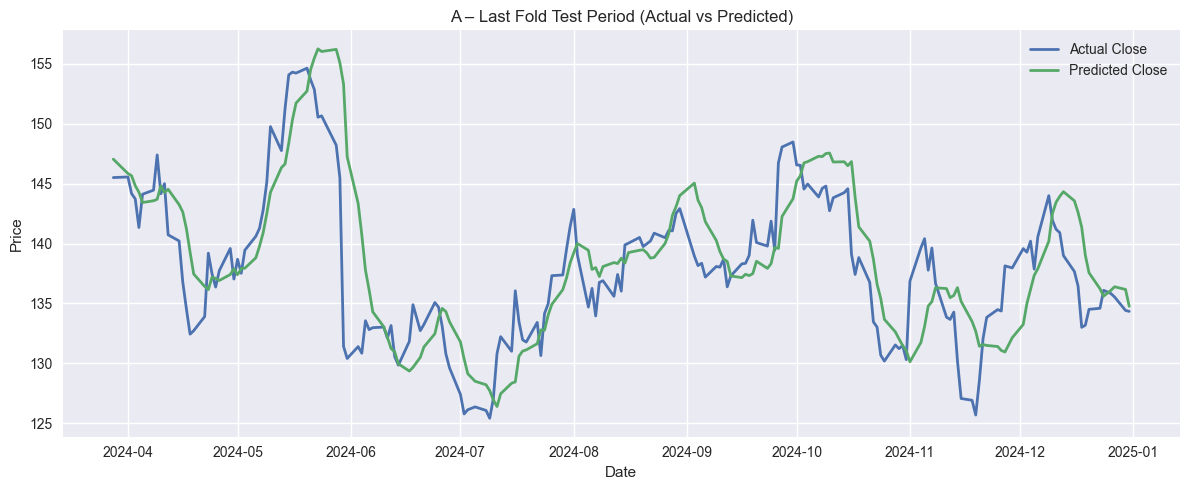

In [65]:
if last_fold_plot_data is not None:
    dates = last_fold_plot_data["dates"]
    actual = last_fold_plot_data["actual"]
    pred = last_fold_plot_data["pred"]

    plt.figure(figsize=(12, 5))
    plt.plot(dates, actual, label="Actual Close", linewidth=2)
    plt.plot(dates, pred, label="Predicted Close", linewidth=2)
    plt.title(f"{target_symbol} – Last Fold Test Period (Actual vs Predicted)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No plot data available (no valid folds).")


In [71]:
# Run Walk-Forward Validation

# Using the same parameters as the original model
wf_results, wf_predictions, wf_actuals, wf_dates = walk_forward_validation(
    stock_df=stock_df,
    feature_columns=feature_columns,
    target_column='Close',
    n_past=60,
    n_folds=5,
    test_size_days=120,   # ~6 months per fold
    num_epochs=50,
    batch_size=32,
    hidden_size=64,
    num_layers=2,
    dropout=0.2,
    learning_rate=1e-3,
    early_stop_patience=10,
    device=device,
    verbose=True
)


FOLD 1/5
Train: 2397 days | Test: 120 days
Train: 2014-01-02 to 2023-07-12
Test:  2023-07-13 to 2024-01-02


KeyError: "['MA20', 'Volatility', 'RSI'] not in index"

In [ ]:
# Walk-Forward Results Table

print("\nDetailed Results by Fold:")
print(wf_results.to_string(index=False))


Detailed Results by Fold:
 fold  train_days  test_days     rmse      mae     mape  directional_accuracy  best_val_loss
    1        2377         60 2.830512 2.117708 1.779623             47.457627       0.000376
    2        2497         60 3.638439 2.470573 1.769857             54.237288       0.000622
    3        2617         60 3.098217 2.430447 1.773679             57.627119       0.000451
    4        2737         60 2.913503 2.142510 1.954450             47.457627       0.000399
    5        2857         60 3.016143 2.388350 1.717066             52.542373       0.000427


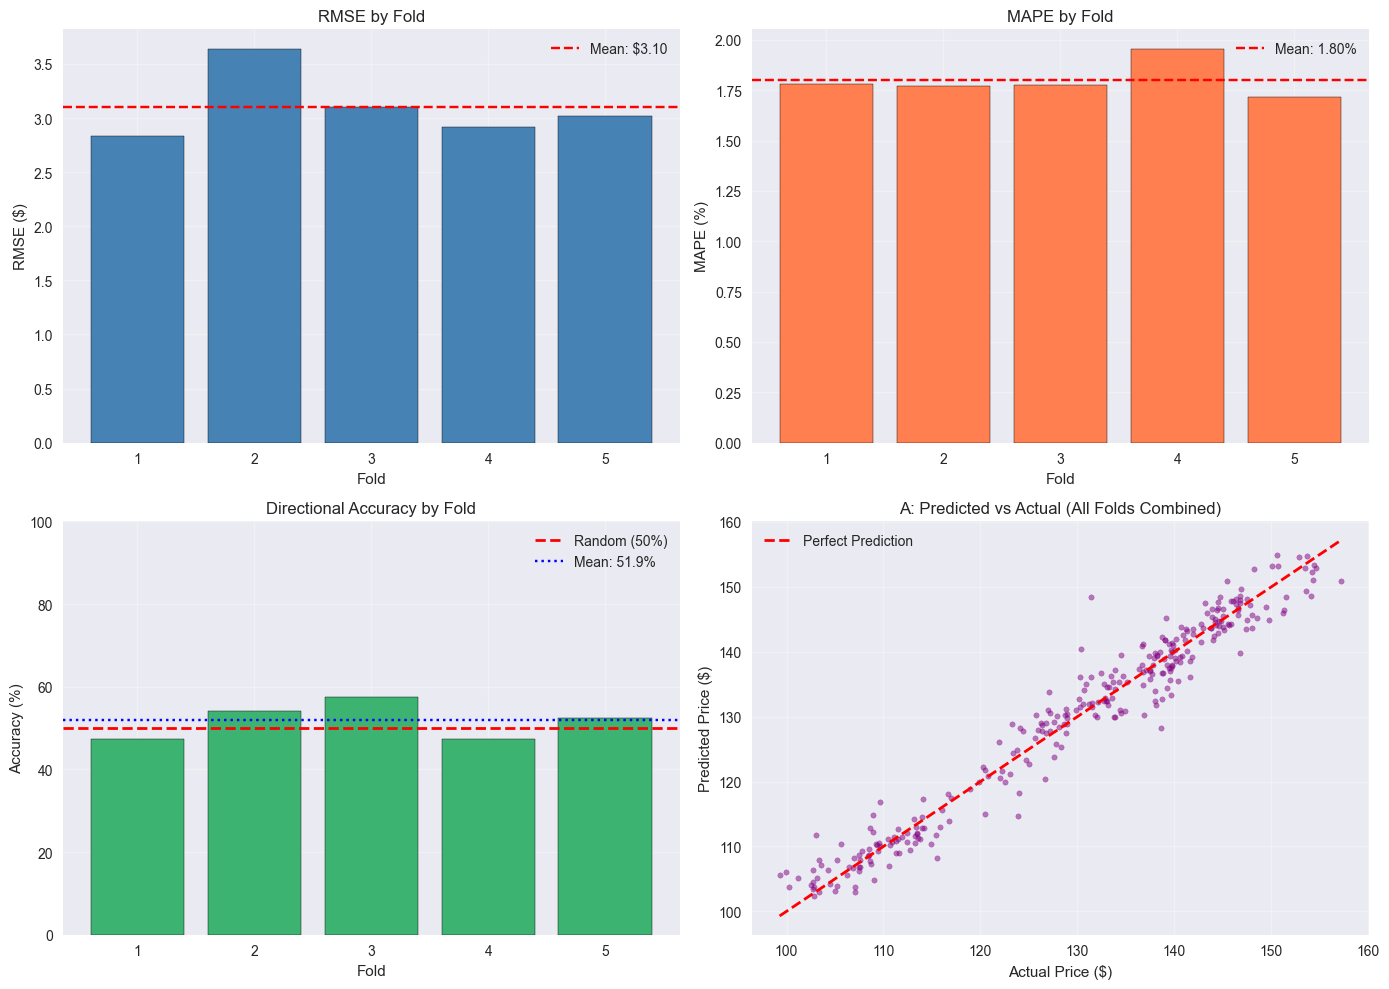

In [ ]:
# Walk-Forward Validation Visualizations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: RMSE by Fold
bars1 = axes[0, 0].bar(wf_results['fold'], wf_results['rmse'], color='steelblue', edgecolor='black')
axes[0, 0].axhline(y=wf_results['rmse'].mean(), color='red', linestyle='--', 
                   label=f'Mean: ${wf_results["rmse"].mean():.2f}')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE ($)')
axes[0, 0].set_title('RMSE by Fold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: MAPE by Fold
bars2 = axes[0, 1].bar(wf_results['fold'], wf_results['mape'], color='coral', edgecolor='black')
axes[0, 1].axhline(y=wf_results['mape'].mean(), color='red', linestyle='--',
                   label=f'Mean: {wf_results["mape"].mean():.2f}%')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAPE (%)')
axes[0, 1].set_title('MAPE by Fold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Directional Accuracy by Fold
bars3 = axes[1, 0].bar(wf_results['fold'], wf_results['directional_accuracy'], 
                       color='mediumseagreen', edgecolor='black')
axes[1, 0].axhline(y=50, color='red', linestyle='--', linewidth=2, label='Random (50%)')
axes[1, 0].axhline(y=wf_results['directional_accuracy'].mean(), color='blue', linestyle=':',
                   label=f'Mean: {wf_results["directional_accuracy"].mean():.1f}%')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Directional Accuracy by Fold')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Predicted vs Actual (All Folds)
axes[1, 1].scatter(wf_actuals, wf_predictions, alpha=0.5, s=15, c='purple')
min_val = min(wf_actuals.min(), wf_predictions.min())
max_val = max(wf_actuals.max(), wf_predictions.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Predicted Price ($)')
axes[1, 1].set_title(f'{target_ticker}: Predicted vs Actual (All Folds Combined)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

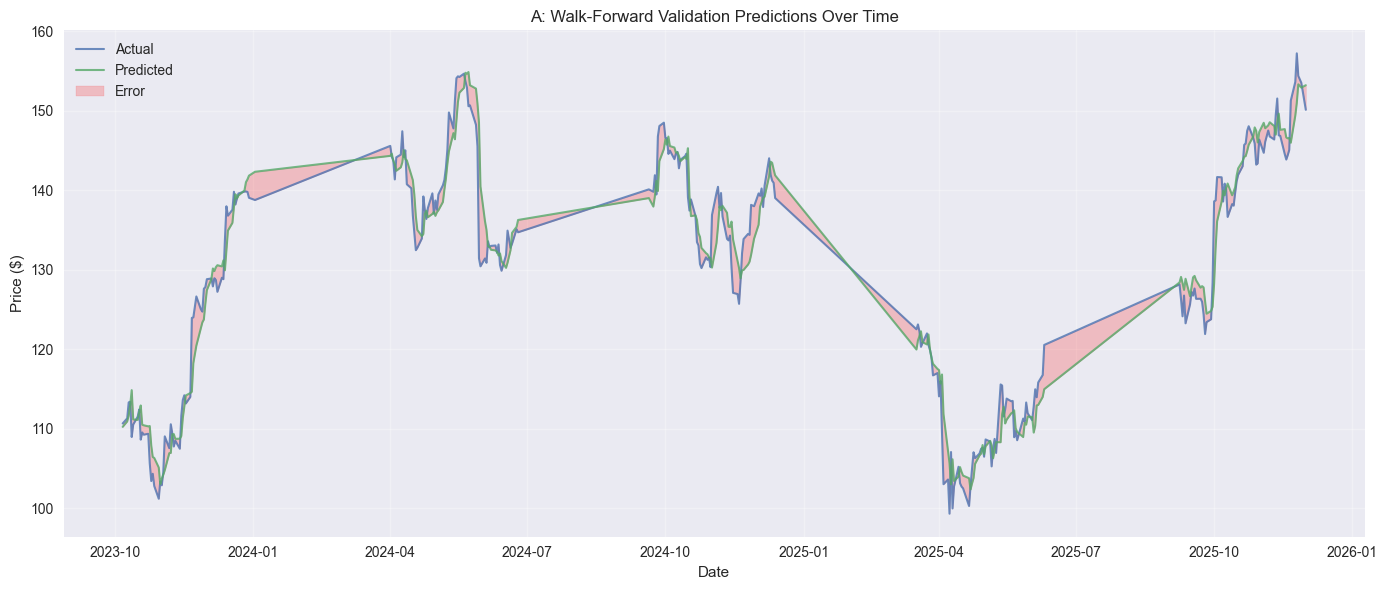

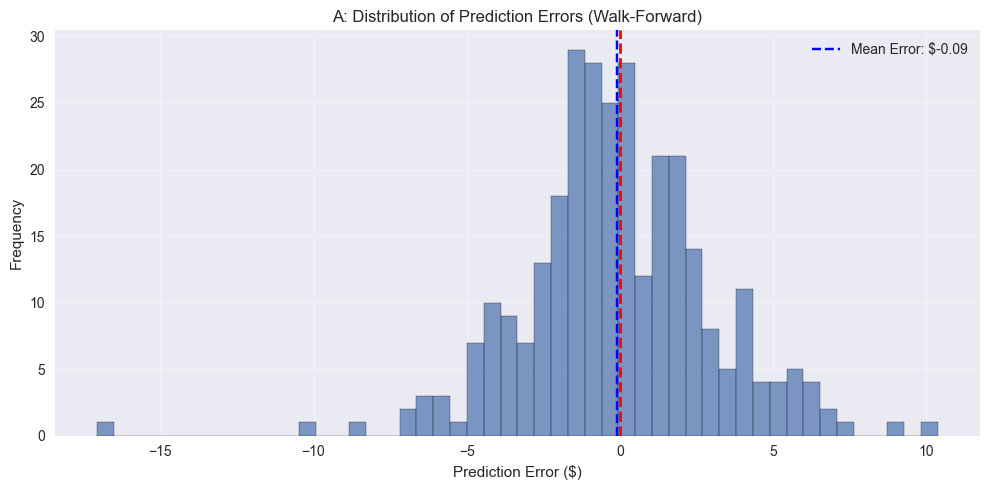

In [ ]:
# Time Series Plot of All Walk-Forward Predictions

plt.figure(figsize=(14, 6))

# Convert dates for plotting
wf_dates_dt = pd.to_datetime(wf_dates)

# Plot actual vs predicted
plt.plot(wf_dates_dt, wf_actuals, label='Actual', linewidth=1.5, alpha=0.8)
plt.plot(wf_dates_dt, wf_predictions, label='Predicted', linewidth=1.5, alpha=0.8)

# Add shaded error region
plt.fill_between(wf_dates_dt, wf_actuals, wf_predictions, alpha=0.2, color='red', label='Error')

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{target_ticker}: Walk-Forward Validation Predictions Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(10, 5))
errors = wf_actuals - wf_predictions
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.axvline(x=errors.mean(), color='blue', linestyle='--', label=f'Mean Error: ${errors.mean():.2f}')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title(f'{target_ticker}: Distribution of Prediction Errors (Walk-Forward)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Compare Original vs Walk-Forward Metrics

print("\n" + "="*70)
print("COMPARISON: Original Single Split vs Walk-Forward Validation")
print("="*70)
print(f"\n{'Metric':<25} {'Original (Single Split)':<25} {'Walk-Forward (Mean±Std)'}")
print("-"*70)
print(f"{'RMSE':<25} ${test_rmse:<24.4f} ${wf_results['rmse'].mean():.4f} ± ${wf_results['rmse'].std():.4f}")
print(f"{'MAE':<25} ${test_mae:<24.4f} ${wf_results['mae'].mean():.4f} ± ${wf_results['mae'].std():.4f}")
print(f"{'MAPE':<25} {test_mape:<24.2f}% {wf_results['mape'].mean():.2f}% ± {wf_results['mape'].std():.2f}%")
print(f"{'Directional Accuracy':<25} {'N/A':<25} {wf_results['directional_accuracy'].mean():.2f}% ± {wf_results['directional_accuracy'].std():.2f}%")
print("="*70)
print("\nNotes:")
print("- Walk-forward provides more robust estimates with uncertainty bounds")
print("- Directional accuracy >50% indicates better than random prediction")
print("- High std dev suggests inconsistent performance across time periods")


COMPARISON: Original Single Split vs Walk-Forward Validation

Metric                    Original (Single Split)   Walk-Forward (Mean±Std)
----------------------------------------------------------------------
RMSE                      $2.8663                   $3.0994 ± $0.3179
MAE                       $2.1373                   $2.3099 ± $0.1669
MAPE                      1.65                    % 1.80% ± 0.09%
Directional Accuracy      N/A                       51.86% ± 4.42%

Notes:
- Walk-forward provides more robust estimates with uncertainty bounds
- Directional accuracy >50% indicates better than random prediction
- High std dev suggests inconsistent performance across time periods
